# Load modules

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set_palette('husl')

from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample

import influxdb 
from dateutil import tz

import ast

%matplotlib inline

# Define runoff functions
from hydrology import scs_composite_CN, scs_excess_precipitation, scs_uh_runoff, precip_data, scs_excess_precipitation

# Simulation  Parameters

In [2]:

## Load pipedream model information 
superjunctions = pd.read_csv('../data/waller_superjunctions.csv', index_col=0)  
superlinks = pd.read_csv('../data/waller_creek_superlinks.csv', index_col=0) 
subbasins = pd.read_csv('../data/Waller_HMS_model_data.csv', index_col=0)

# Specify simulation parameters
# Unit conversions
m_per_ft = 0.3048
ft_per_mi = 5280.
in_per_ft = 12.
s_per_min = 60
ns_per_s = 1e9

# Manual edits to model
superlinks.loc[20, ['g2', 'g3']] = 5.6, 6.3
superlinks.loc[21, ['g2', 'g3']] = 3.7, 3.977146367746631
superlinks.loc[22, ['g2', 'g3']] = 0., 7.777146367746631
superlinks.loc[23, ['g2', 'g3']] = 0., 8.3714367746631
superlinks['C_uk'] = 0.
superlinks['C_dk'] = 0.
superjunctions.loc[16, ['z_inv']]=147.9


# Simulation params
sample_interval = 30
site_junction_name = 'J_WLR18_COMB_HEMP'
site_link_name = 'R_WLR16'
site_junction_index = 14
site_link_index = 21

# Load unit hydrograph
# Load dimensionless unit hydrograph
uh__dimless = pd.read_csv('../data/unit_hydrograph.csv')
# Drop unnecessary columns and rows
uh__dimless = uh__dimless[['time ratios', 'discharge ratios']].dropna()
dt = 10

# Set up Kalman filtering parameters
n = len(superjunctions)
p = n
m = 4

process_std_dev = 1e-2
measurement_std_dev = 2e-4

H_kal = np.zeros((m, n))
H_kal[0, 13] = 1.
H_kal[1, 14] = 1.
H_kal[2, 15] = 1.
H_kal[3, 16] = 1.
Qcov = (process_std_dev**2)*np.eye(p)
Rcov = (measurement_std_dev**2)*np.eye(m)

C_kal = np.zeros((n, p))
C_kal[np.arange(n), np.arange(p)] = 1.

# Load precipitation data

In [3]:
# Add LCRA data (Flow, depth, and precipitation data for the 'Waller Creek at 23rd Street' gage from the LCRA site.)
LCRA= pd.read_excel('../data/LCRA_Export/LCRA_Export_2023.xlsx')[8:]
LCRA = LCRA.set_index('Site Name')
LCRA.index.name = 'Time'
# Handle timezone
LCRA = LCRA.tz_localize('US/Central', nonexistent='shift_forward').tz_convert('UTC')
# Rename columns to be more descriptive
LCRA = LCRA.rename(columns={'W3A' : 'depth__ft', 'W3A.1' : 'flow_rate__cfs', 'W3A.3' : 'precip_tot__in'})
LCRA = LCRA.drop('W3A.2', axis=1)


In [4]:
forecast = pd.read_csv('../data/rainfall_data/precip__in_forecast.csv', index_col=0)
forecast.index = pd.to_datetime(pd.Series(forecast.index))
forecast = forecast.tz_localize('UTC')

# Compute inches of precipitation for desired sample interval
forecast_precip_in = sample_interval * forecast['precip_rate__in_per_s'].resample(f'{sample_interval}s').mean().interpolate()


In [5]:
def precip_data(LCRA, start_date, end_date):
    LCRA = LCRA.loc[start_date:end_date]

    # Compute dt for each time bin
    LCRA['dt__s'] = np.roll(pd.Series(LCRA.index).diff(1).dt.seconds.values, -1)
    LCRA['dt__s'] = LCRA['dt__s'].fillna(method='ffill')
    # Compute precipitation rate from total inches and dt
    LCRA['precip_rate__in_per_s'] = LCRA['precip_tot__in'] / LCRA['dt__s']

    # Compute inches of precipitation for desired sample interval
    precip__in = sample_interval * LCRA['precip_rate__in_per_s'].astype(np.float64).resample(f'{sample_interval}s').mean().interpolate()
    return precip__in

# Load Sensor depth data 

In [6]:
bridge_2 = pd.read_csv('../data/sensor_measurements/bridge2_classification.csv', index_col=0)['Bridge2']
bridge_2.index = pd.to_datetime(bridge_2.index)
bridge_3 = pd.read_csv('../data/sensor_measurements/bridge3_classification.csv', index_col=0)['Bridge3']
bridge_3.index = pd.to_datetime(bridge_3.index)
bridge_4 = pd.read_csv('../data/sensor_measurements/bridge4_classification.csv', index_col=0)['Bridge4']
bridge_4.index = pd.to_datetime(bridge_4.index)
bridge_5 = pd.read_csv('../data/sensor_measurements/bridge5_classification.csv', index_col=0)['Bridge5']
bridge_5.index = pd.to_datetime(bridge_5.index)

In [7]:
# Compute runoff into each superjunction
def Model_initialization(precip__in,subbasins,P_now,decay_function=lambda x: 0.):
    keepGoing=True
    while keepGoing:
        try:
            Q_in = {}
            CNs = []
            # Manual edits to hydrology params
            lag_time_adjust_ratio = 1.0
            CN_adjust_ratio = 1.0


            # For each subbasin...
            for i in range(len(subbasins)):
                Pnow = P_now
                # Load subbasin parameters
                CN_C = subbasins['Curve Number'][i]
                A_Imp = subbasins['Impervious Percent'][i]
                area__sq_mi = subbasins['Area (mi2)'][i]
                downstream = subbasins['Downstream'][i]
                lag_time__min = subbasins['Lag Time'][i] * lag_time_adjust_ratio

                # Compute composite curve number
                CN = scs_composite_CN(CN_C, A_Imp) * CN_adjust_ratio
                CN = min(CN, 98)

                # Compute excess precipitation
                excess_precip_cum__in, excess_precip__in, P_now = scs_excess_precipitation(precip__in, CN,Pnow,decay_function=decay_function)

                # Compute runoff using unit hydrograph
                runoff__cms = scs_uh_runoff(excess_precip__in, uh__dimless, area__sq_mi, sample_interval,lag_time__min)
                Q_in[downstream] = runoff__cms

            # Format flow input as DataFrame
            Q_in = pd.DataFrame.from_dict(Q_in)
            # Add flow input for missing sites
            Q_in['UPSTREAM_WALLER'] = Q_in['R_WLR01']
            Q_in['UPSTREAM_HEMPHILL'] = Q_in['R_HEM01']
            Q_in[[name for name in superjunctions['name'] if not name in Q_in.columns]] = 0.
            # Ensure flow input is only for superjunctions specified in table
            Q_in = Q_in[superjunctions['name'].tolist()]
            # Remove NaN values
            Q_in = Q_in.fillna(0.)
            # Copy flow input with original timestamps
            Q_in_orig = Q_in.copy()
            # Convert flow input index to integer index starting with zero
            Q_in.index = Q_in.index.astype(int) / 1e9
            Q_in.index -= Q_in.index.min()
            keepGoing=False
        
        except ValueError:
            keepGoing=True
        except KeyError :
            keepGoing=True
        except AssertionError:
            keepGoing=True


    return excess_precip__in,Q_in,P_now

In [8]:
# Run simulation without KF
def Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,measurements,load_data,stop_kf_time):
    
    keepGoing=True
    while keepGoing:
        try:

            superlink = SuperLink(superlinks, superjunctions,internal_links=30, mobile_elements=True)
            

            H_j = []
            h_Ik = []
            Q_uk = []
            Q_dk = []
            residuals = []
            scores = []

            # Set constant timestep (in seconds)

            # Add constant baseflow
            baseflow = 0.35e-3 * np.ones(superlink._h_Ik.size)

            # Create simulation context manager
            with Simulation(superlink, Q_in=Q_in, Qcov=Qcov, Rcov=Rcov,
                        C=C_kal, H=H_kal, interpolation_method='nearest') as simulation:
                simulation.model.load_state(load_data)
                # While simulation time has not expired...
                while simulation.t <= simulation.t_end:
                    # Step model forward in time
                    simulation.step(dt=dt, num_iter=8, Q_Ik=baseflow)
                    # Get measured value
                    cond_kf = simulation.t < stop_kf_time
                    if cond_kf:
                        next_measurement = interpolate_sample(simulation.t,
                                                          measurements.index.values,
                                                          measurements.values,
                                                          method=0)
                        # Apply Kalman filter with measured value
                        H = H_kal
                        C = C_kal
                        Z_next = next_measurement
                        P_x_k_k = simulation.P_x_k_k
                        A_1, A_2, b = simulation.model._semi_implicit_system(_dt=dt)
                        I = np.eye(A_1.shape[0])
                        y_k1_k = b
                        A_1_inv = np.linalg.inv(A_1)
                        H_1 = H @ A_1_inv

                        residual = (Z_next - H_1 @ y_k1_k)
                        residuals.append(residual)
                        
                        cond = residual**2 > 0.5


                        if (cond).any():
                            H_mod = H[~cond]
                            H_1 = H_mod @ A_1_inv
                            Rcov_mod = Rcov[~cond][:, ~cond]
                            Z_next = Z_next[~cond]
                        else:
                            H_mod = H
                            Rcov_mod = Rcov

                        P_y_k1_k = A_2 @ P_x_k_k @ A_2.T + C @ Qcov @ C.T
                        L_y_k1 = P_y_k1_k @ H_1.T @ np.linalg.inv((H_1 @ P_y_k1_k @ H_1.T) + Rcov_mod)
                        P_y_k1_k1 = (I - L_y_k1 @ H_1) @ P_y_k1_k
                        b_hat = y_k1_k + L_y_k1 @ (Z_next - H_1 @ y_k1_k)
                        P_x_k1_k1 = A_1_inv @ P_y_k1_k1 @ A_1_inv.T
                        #if score < 1e-7:
                        simulation.P_x_k_k = P_x_k1_k1
                        simulation.model.b = b_hat
                        simulation.model.iter_count -= 1
                        simulation.model.t -= dt
                        simulation.model._solve_step(dt=dt)

                    #simulation.kalman_filter(next_measurement, dt=dt)
                    simulation.model.reposition_junctions()
                    # Print progress bar
                    simulation.print_progress()
                    # Save states
                    H_j.append(simulation.model.H_j.copy())
                    h_Ik.append(simulation.model.h_Ik.copy())
                    Q_uk.append(simulation.model.Q_uk.copy())
                    Q_dk.append(simulation.model.Q_dk.copy())

            time_index = pd.date_range(start=excess_precip__in.index.min(), 
                                               periods=len(H_j), 
                                               freq=f'{dt}s')

            # Convert saved states to dataframes
            H_j = pd.DataFrame(np.vstack(H_j), index=time_index, columns=superjunctions['name'])
            h_Ik = pd.DataFrame(np.vstack(h_Ik), index=time_index)
            Q_uk = pd.DataFrame(np.vstack(Q_uk), index=time_index, columns=superlinks['name'])
            Q_dk = pd.DataFrame(np.vstack(Q_dk), index=time_index, columns=superlinks['name'])
            

            # Compute depth
            h_j = H_j - simulation.model._z_inv_j

            final_data=simulation.model.states

            keepGoing=False
        
        except ValueError:
            keepGoing=True
        except KeyError :
            keepGoing=True
        except AssertionError:
            keepGoing=True
    
    return H_j,h_Ik,Q_uk,Q_dk,h_j,final_data

## Model_forecast

In [9]:

stop_kf_time=0
start_date_forecast='20230404 00:00:00'
end_date_forecast='20230521 00:00:00'
precip__in= forecast_precip_in.loc[start_date_forecast:end_date_forecast]


In [10]:
P_now = 0
final_data={}
if precip__in.empty != True:
    excess_precip__in,Q_in,P_now=Model_initialization(precip__in,subbasins,P_now,decay_function=lambda x: (1 - 0.9974)*x)
    
    measurements = pd.concat([bridge_2.resample('5min').mean().interpolate(method='nearest'),
                              bridge_5.resample('5min').mean().interpolate(method='nearest'),
                          bridge_3.resample('5min').mean().interpolate(method='nearest'),
                          bridge_4.resample('5min').mean().interpolate(method='nearest')
                             ], axis=1).interpolate()
    measurements = measurements.fillna(method='backfill')
    measurements = measurements + superjunctions.loc[[13, 14, 15, 16], 'z_inv'].values
    measurements.index = measurements.index - precip__in.index.min()
    measurements.index = measurements.index.astype(int) / 1e9    
    H_j,h_Ik,Q_uk,Q_dk,h_j,final_data=Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,measurements,final_data,stop_kf_time)
    final_data['t']=0

h_j_forecast = h_j.copy()
Q_uk_forecast = Q_uk.copy()

[==================================================] 100.0% [793.57 s]

## Model_raingauge

In [11]:


stop_kf_time = 0
start_date_raingauge='20230404 00:00:00'
end_date_raingauge='20230521 00:00:00'

precip__in=precip_data(LCRA, start_date_raingauge, end_date_raingauge)

/var/folders/0z/96nhv68546j11lkz0bh80tqw0000gp/T/ipykernel_50825/67319582.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LCRA['dt__s'] = np.roll(pd.Series(LCRA.index).diff(1).dt.seconds.values, -1)
/var/folders/0z/96nhv68546j11lkz0bh80tqw0000gp/T/ipykernel_50825/67319582.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LCRA['dt__s'] = LCRA['dt__s'].fillna(method='ffill')
/var/folders/0z/96nhv68546j11lkz0bh80tqw0000gp/T/ipykernel_50825/67319582.py:8: SettingWithCopyWarning: 
A value is trying to be s

In [12]:
P_now = 0
final_data={}
if precip__in.empty != True:
    excess_precip__in,Q_in,P_now=Model_initialization(precip__in,subbasins,P_now,decay_function=lambda x: (1 - 0.9974)*x)
    
    measurements = pd.concat([bridge_2.resample('5min').mean().interpolate(method='nearest'),
                              bridge_5.resample('5min').mean().interpolate(method='nearest'),
                          bridge_3.resample('5min').mean().interpolate(method='nearest'),
                          bridge_4.resample('5min').mean().interpolate(method='nearest')
                             ], axis=1).interpolate()
    measurements = measurements.fillna(method='backfill')
    measurements = measurements + superjunctions.loc[[13, 14, 15, 16], 'z_inv'].values
    measurements.index = measurements.index - precip__in.index.min()
    measurements.index = measurements.index.astype(int) / 1e9    
    H_j,h_Ik,Q_uk,Q_dk,h_j,final_data=Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,measurements,final_data,stop_kf_time)
    final_data['t']=0
    
h_j_gauge = h_j.copy()
Q_uk_gauge = Q_uk.copy()

[==================================================] 100.0% [768.05 s]

# J_WLR16_32ND

Text(0, 0.5, 'Depth(m)')

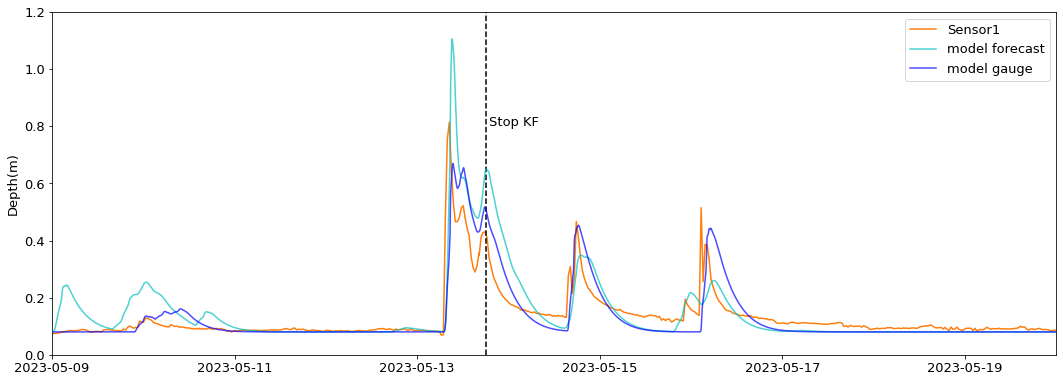

In [13]:
site_junction_name = 'J_WLR16_32ND'
site_junction_index = 13
fig, ax = plt.subplots(1,figsize=(18, 7))
ax.plot(bridge_2, c='tab:orange', label='Sensor1')

h_j_forecast.loc['20230509 00:00:00':'20230520 00:00:00', site_junction_name].plot(ax=ax, label='model forecast', c='c', alpha=0.7, zorder=5)
h_j_gauge[site_junction_name].plot(ax=ax, label='model gauge', c='blue', alpha=0.7, zorder=5 )
plt.xlim('20230509 00:00:00', '20230520 00:00:00')
plt.ylim(0, 1.2)
plt.axvline('20230513 18:00:00', linestyle='--', c='k')
plt.text('20230513 19:00:00', 0.8, 'Stop KF', fontsize='13')
plt.legend( fontsize='13')
plt.xticks(rotation=0,ha='center', fontsize='13')
plt.yticks( fontsize='13')
plt.ylabel('Depth(m)', fontsize='13')

# Save model results

In [ ]:
# h_j_forecast['J_WLR16_32ND'].to_csv('h_j_forecast_h1.csv')
# h_j_gauge['J_WLR16_32ND'].to_csv('h_j_gauge_h1.csv')
# h_j_forecast['J_WLR18_COMB_HEMP'].to_csv('h_j_forecast_h2.csv')
# h_j_gauge['J_WLR18_COMB_HEMP'].to_csv('h_j_gauge_h2.csv')
# h_j_forecast['J_WLR19_23RD'].to_csv('h_j_forecast_h3.csv')
# h_j_gauge['J_WLR19_23RD'].to_csv('h_j_gauge_h3.csv')
# h_j_forecast['J_WLR20_TRINITY'].to_csv('h_j_forecast_h4.csv')
# h_j_gauge['J_WLR20_TRINITY'].to_csv('h_j_gauge_h4.csv')


In [ ]:

# h_j_forecast['J_WLR19_23RD'].to_csv('h_j_forecast_h3.csv')
# h_j_gauge['J_WLR19_23RD'].to_csv('h_j_gauge_h3.csv')

# Q_uk_forecast['R_WLR16'].to_csv('Q_uk_forecast_h2.csv')
# Q_uk_gauge['R_WLR16'].to_csv('Q_uk_gauge_h2.csv')
# Q_uk_forecast['R_WLR17'].to_csv('Q_uk_forecast_h3.csv')
# Q_uk_gauge['R_WLR17'].to_csv('Q_uk_gauge_h3.csv')
